In [5]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# Import local libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
import sklearn.metrics

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.facecolor"] = "white"

Read the data file.

In [18]:
# Import the main data set
home_dir = os.path.expanduser("~")
data = pd.read_pickle(f'{home_dir}/Documents/github/CIV1498-Project2/dataframes/df_LA_parcels_LAcity_cleaned_REV3_MB.pkl', compression = "gzip")
data = data[data['TotalValue'] <= 2000000]
data = data[data['Neighborhood'].str.contains('Griffith Park') == False] # This is an outlier

In [9]:
data.shape

(417991, 25)

In [ ]:
# Import the number of crimes committed in each neighborhood from 2010 to 2019
crime_data = pd.read_csv(f'{home_dir}/Documents/github/CIV1498-Project2/datasets/neighbourhoods_crime_count_2010_to_2019.csv')
crime_data = crime_data[['name', 'crime_count']].rename(columns = {'name': 'Neighborhood'})
data = data.merge(crime_data, on = 'Neighborhood')
data

In [ ]:
# Import the custom clustering from the EDA section of this project.
# Clustered based on geographical area and median TotalValue to distinguish between rich and poor neighborhoods
neighborhood_cluster_data = pd.read_pickle(f'{home_dir}/Documents/github/CIV1498-Project2/dataframes/neighborhoods_cluster.pkl')
neighborhood_cluster_data['cluster'] = neighborhood_cluster_data['cluster'].astype(int) # Convert from object to int
data = data.merge(neighborhood_cluster_data[['Neighborhood', 'cluster']], on = 'Neighborhood')
data

Drop irrelevant columns.

In [21]:
data = data.drop(columns = ['AIN', 'Cluster', 'ZIPcode5', 'ZIPcode4', 'geometry'])
data

,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,TaxRateArea,...,Neighborhood,C_score,BI_score,ID_score,Wd_score,LL_score,ShapeSTAre,ShapeSTLen,crime_count,cluster
0,1650.0,4,2,236718.0,2011,368094.0,1963,1963,0100,16,...,Canoga Park,1,1,1,1,1,8115.922852,377.443437,4405,4
1,1327.0,3,2,135211.0,1989,338036.0,1957,1957,0100,16,...,Canoga Park,1,1,1,1,1,8399.689453,379.990318,4405,4
2,714.0,2,1,246192.0,2003,307598.0,1953,1953,0100,16,...,Canoga Park,1,1,1,1,1,6749.179688,369.982730,4405,4
3,1657.0,3,2,212535.0,1989,279800.0,1956,1966,0100,16,...,Canoga Park,1,1,1,1,1,7629.740234,358.002982,4405,4
4,1876.0,6,2,285871.0,1990,407892.0,1942,1947,0101,8852,...,Canoga Park,1,1,1,1,1,13498.103516,469.973496,4405,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417986,2187.0,4,3,654147.0,2018,830954.0,1955,1963,0100,14,...,San Pedro,1,1,1,1,1,6029.481445,322.234960,8957,4
417987,1305.0,3,2,609000.0,2007,762000.0,1955,1955,0100,14,...,San Pedro,1,1,1,1,1,8677.246094,402.365689,8957,4
417988,1910.0,3,2,51162.0,1975,124294.0,1961,1961,0100,308,...,San Pedro,1,1,1,1,1,6747.458984,334.916599,8957,4
417989,4541.0,4,4,492258.0,2013,1251407.0,2007,2007,0100,20,...,San Pedro,1,1,1,1,1,6000.456055,320.017959,8957,4


Check out the correlation between each of the current features of the data set.

In [22]:
correlation = data.corr()

<AxesSubplot:>

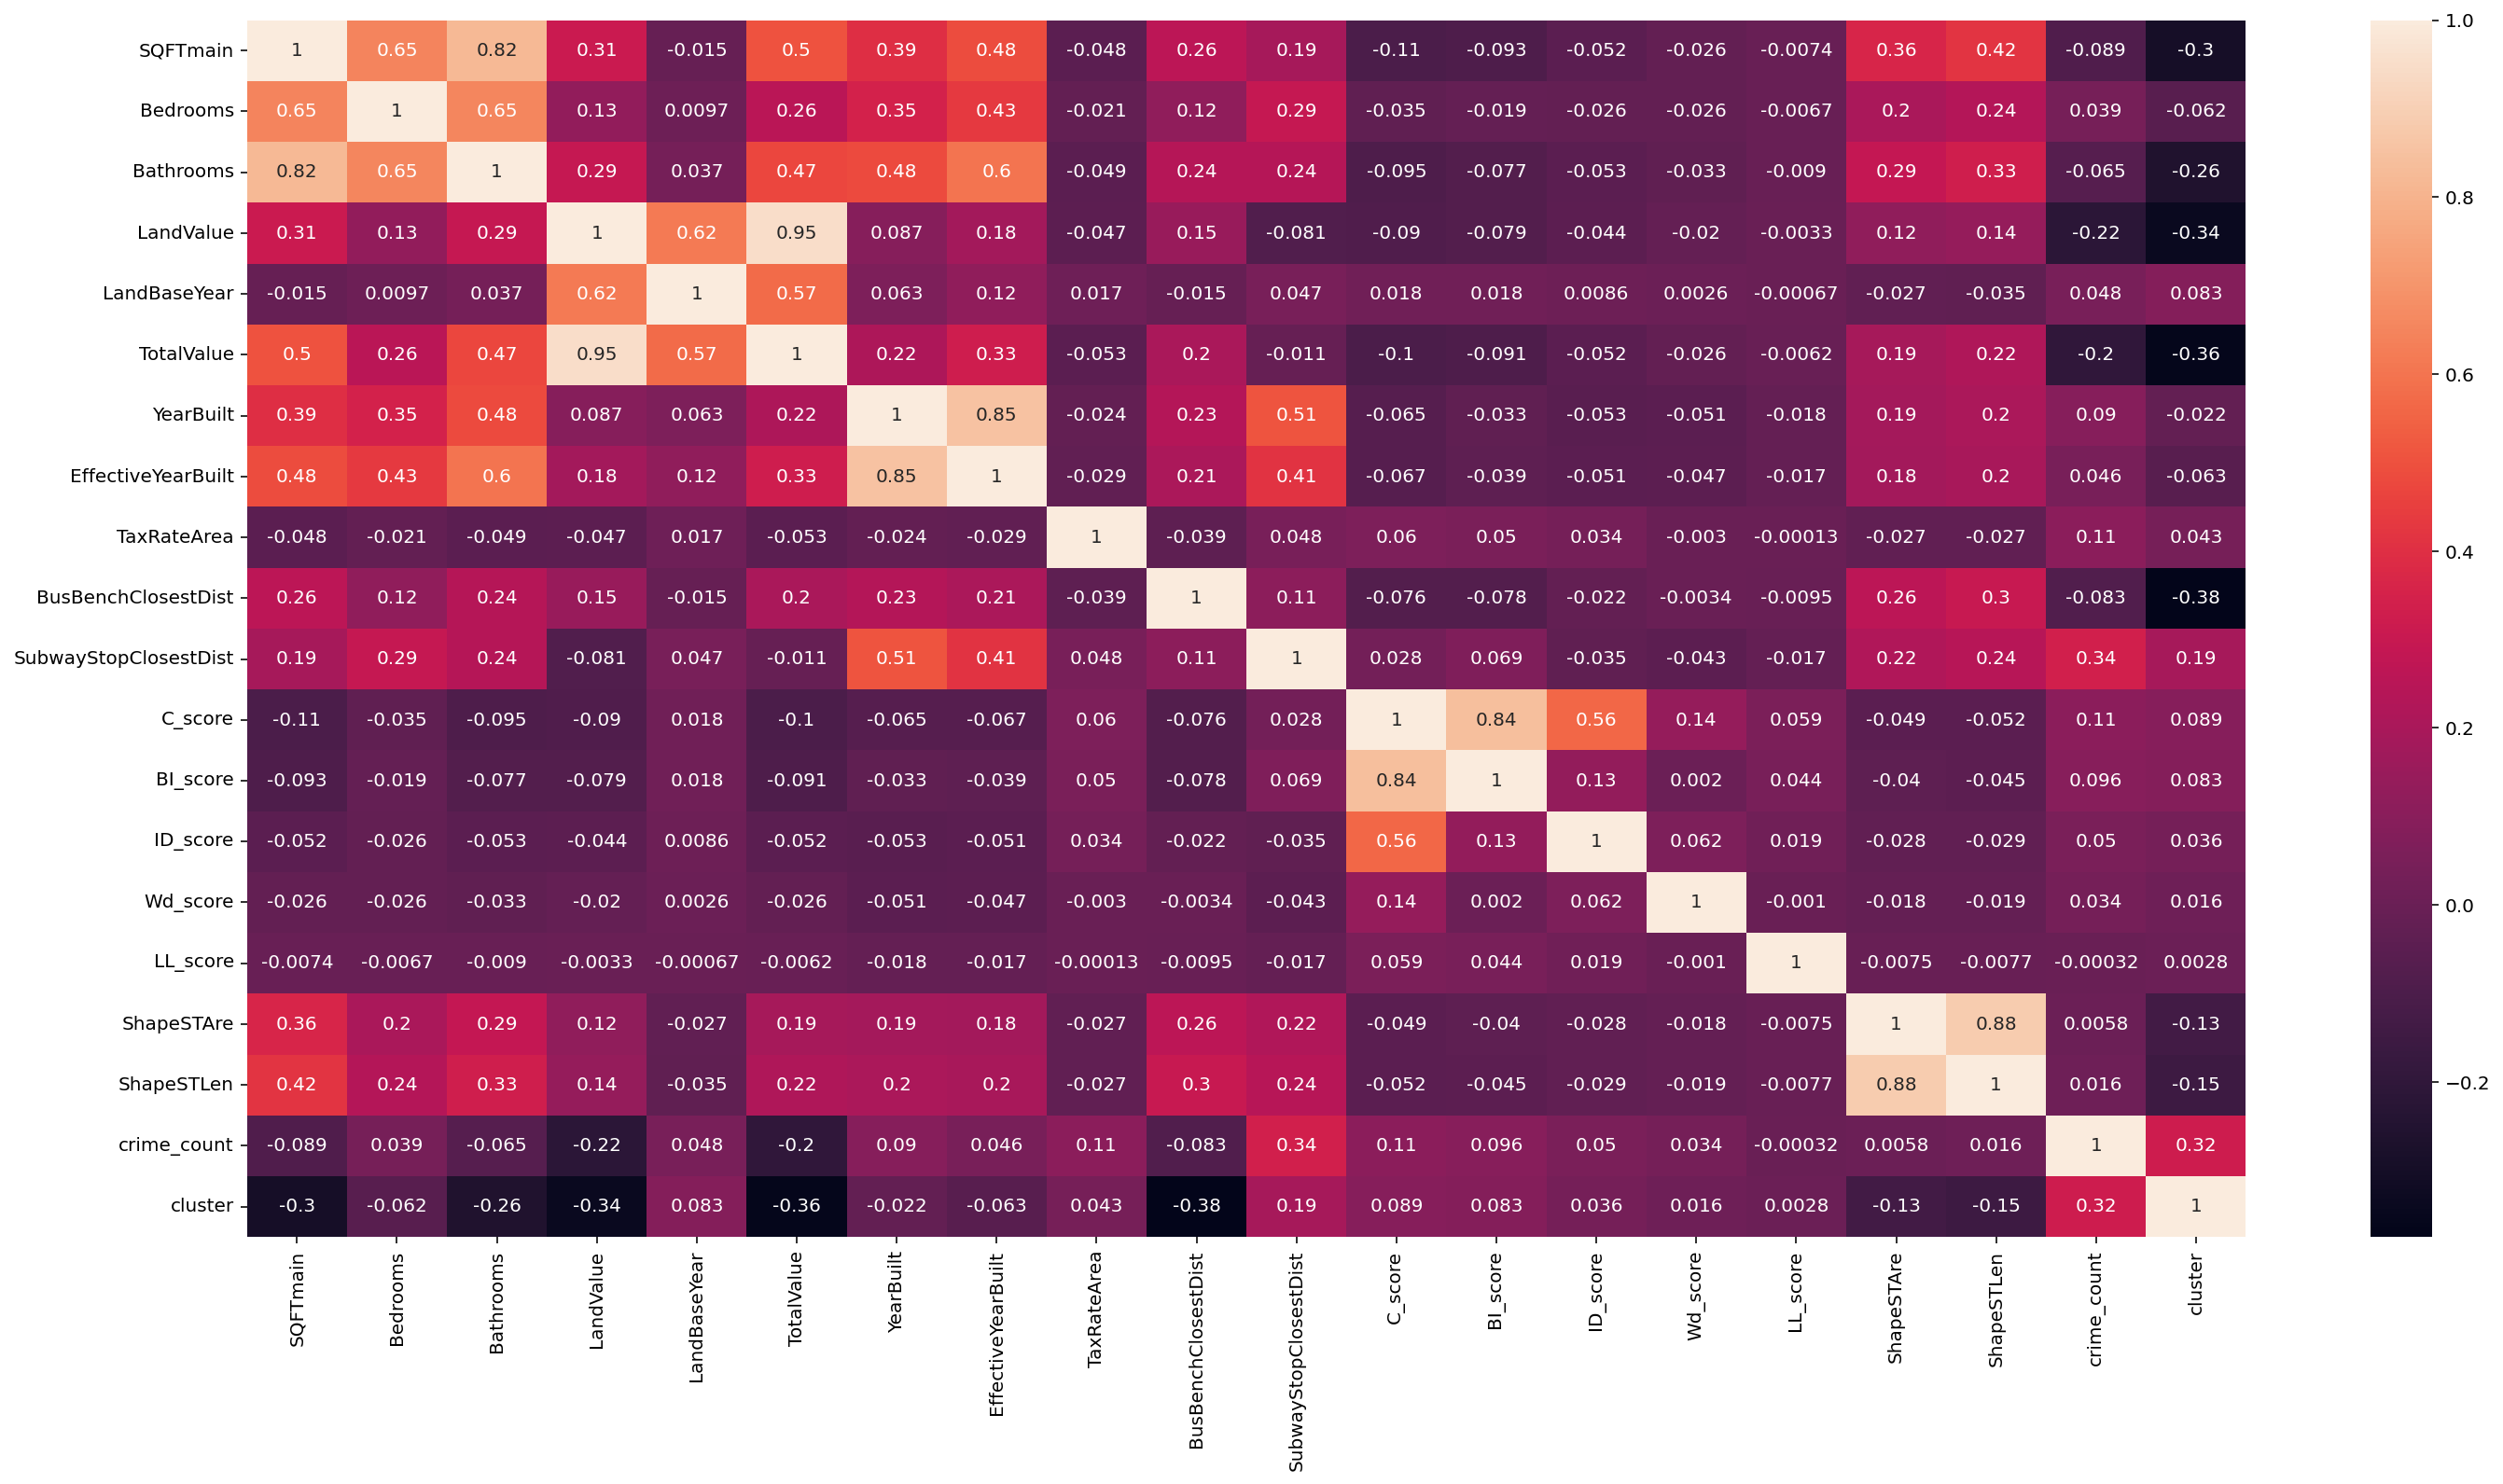

In [27]:
plt.figure(figsize = (24, 12))
sns.heatmap(correlation, annot=True)

Look at the info of each column in the data set.

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417991 entries, 0 to 417990
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   SQFTmain               417991 non-null  float64
 1   Bedrooms               417991 non-null  int64  
 2   Bathrooms              417991 non-null  int64  
 3   LandValue              417991 non-null  float64
 4   LandBaseYear           417991 non-null  int64  
 5   TotalValue             417991 non-null  float64
 6   YearBuilt              417991 non-null  int64  
 7   EffectiveYearBuilt     417991 non-null  int64  
 8   PropertyUseCode        417991 non-null  object 
 9   TaxRateArea            417991 non-null  int64  
 10  BusBenchClosestDist    417991 non-null  float64
 11  SubwayStopClosestDist  417991 non-null  float64
 12  Neighborhood           417991 non-null  object 
 13  C_score                417991 non-null  int64  
 14  BI_score               417991 non-nu

In [29]:
data.isnull().sum()

SQFTmain                 0
Bedrooms                 0
Bathrooms                0
LandValue                0
LandBaseYear             0
TotalValue               0
YearBuilt                0
EffectiveYearBuilt       0
PropertyUseCode          0
TaxRateArea              0
BusBenchClosestDist      0
SubwayStopClosestDist    0
Neighborhood             0
C_score                  0
BI_score                 0
ID_score                 0
Wd_score                 0
LL_score                 0
ShapeSTAre               0
ShapeSTLen               0
crime_count              0
cluster                  0
dtype: int64

Label the data into groups based on TotalValue, split into 4 groups. This is for stratifying the dataset when splitting into train, test, val sets so that the data split is balanced.

In [30]:
# Group the data into Quartiles based on TotalValue for stratifying purposes
data['Quartile_Number'] = 0

data.loc[
    (data['TotalValue'] >= 0) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.25)), 
    'Quartile_Number'] = 1

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.25)) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.5)), 
    'Quartile_Number'] = 2

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.5)) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.75)), 
    'Quartile_Number'] = 3

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.75)), 
    'Quartile_Number'] = 4

Split the data into training set, validation set, and test set.

In [31]:
train, evaluate = train_test_split(data, test_size = 0.3, random_state = 0, stratify=data['Quartile_Number'])
val, test = train_test_split(evaluate, test_size = 0.5, random_state = 0, stratify=evaluate['Quartile_Number'])

# Print results
print('Train {}%'.format(train.shape[0] / data.shape[0] * 100))
print('Val {}%'.format(val.shape[0] / data.shape[0] * 100))
print('Test {}%'.format(test.shape[0] / data.shape[0] * 100))

Train 69.9998325322794%
Val 15.000083733860297%
Test 15.000083733860297%


## Feature Engineering

## Gradient Descent

    columns = [
     'SQFTmain',
     'Bedrooms',
     'Bathrooms',
     'LandValue',
     'LandBaseYear',
     'YearBuilt',
     'EffectiveYearBuilt',
     'ShapeSTAre',
     'ShapeSTLen',
     'crime_count',
     'YearBuilt_median',
     'EffectiveYearBuilt_median',
     'SQFTmain_median',
     'cluster'
     'Quartile_Number'
    ]
Potential columns of interest

In [32]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [33]:
# Standardize features using standard scaling
def standardize_data(data, columns):
    """
    Standardize all the data to be number of std away from the mean.
    """
    
    for column in columns:
        data[column] = (data[column] - data[column].mean())/data[column].std()
    
    return data

### Try with Four Features

In [34]:
def process_data_GD(data):
    """Combine all pipelines to create processed data."""
    # Transform Data, Select Features
    data = select_columns(data, 
                         'SQFTmain',
                         'Quartile_Number',
                         'LandBaseYear',
                         'TotalValue',
                         'LandValue'
                         )
    
    # Standardize Data using Standard Scaling
    columns = [
     'SQFTmain',
     'Quartile_Number',
     'LandBaseYear',
     'LandValue'
    ]
    
    data = standardize_data(data, columns)
    
    # Return predictors and response variables separately
    X = data.drop(['TotalValue'], axis = 1)
    y = data.loc[:, 'TotalValue']
    
    return X, y

In [35]:
X_train, y_train = process_data_GD(train)
    
X_train.head()

,SQFTmain,Quartile_Number,LandBaseYear,LandValue
117020,-0.535347,0.447118,0.887178,0.703906
102924,1.210640,1.341491,1.356438,3.134364
78262,0.729679,1.341491,0.619029,1.497796
156735,-0.490257,-0.447255,0.216806,-0.419542
186136,1.654026,1.341491,0.417918,1.129305


In [36]:
def mse(theta0, theta1, theta2, theta3, theta4, X, y):
    y_hat = theta0 + theta1*X.iloc[:, 0] + theta2*X.iloc[:, 1] + theta3*X.iloc[:, 2] + theta4*X.iloc[:, 3]
    return np.mean((y_hat - y) ** 2)

def grad_mse(theta0, theta1, theta2, theta3, theta4, X, y):
    y_hat = theta0 + theta1*X.iloc[:, 0] + theta2*X.iloc[:, 1] + theta3*X.iloc[:, 2] + theta4*X.iloc[:, 3]
    n = X.shape[0]
    grad_0 = (-2 / n) * sum(y - y_hat)
    grad_1 = (-2 / n) * sum(X.iloc[:, 0] * (y - y_hat)) 
    grad_2 = (-2 / n) * sum(X.iloc[:, 1] * (y - y_hat)) 
    grad_3 = (-2 / n) * sum(X.iloc[:, 2] * (y - y_hat)) 
    grad_4 = (-2 / n) * sum(X.iloc[:, 3] * (y - y_hat)) 
    return grad_0, grad_1, grad_2, grad_3, grad_4

In [37]:
def minimize_GD(epochs, loss_fn, grad_loss_fn, X, y, alpha=0.2):
    """
    Uses gradient descent to minimize loss_fn. Returns the minimizing value of
    theta once all thetas change less than 0.001 between iterations.
    """
    
    # Set starting epoch
    epochs = np.arange(epochs)
    epochs_conv = []
    
    # Set loss array
#     losses = []
    losses_conv = []
    
    # Set theta array
#     theta0s = []
#     theta1s = []
#     theta2s = []
#     theta3s = []
#     theta4s = []
    
    # Set starting theta
    theta0 = 10
    theta1 = 10
    theta2 = 10
    theta3 = 10
    theta4 = 10
    
    for epoch in epochs:

        # Update losses
#         losses.append(loss_fn(theta0, theta1, theta2, theta3, theta4, X, y))
        
        # Update thetas
#         theta0s.append(theta0)
#         theta1s.append(theta1)
#         theta1s.append(theta2)
#         theta1s.append(theta3)
#         theta1s.append(theta4)
        
        # Compute gradient
        grad_0, grad_1, grad_2, grad_3, grad_4 = grad_loss_fn(theta0, theta1, theta2, theta3, theta4, X, y)
        
        # Get new theta
        new_theta0 = theta0 - alpha * grad_0
        new_theta1 = theta1 - alpha * grad_1
        new_theta2 = theta2 - alpha * grad_2
        new_theta3 = theta3 - alpha * grad_3
        new_theta4 = theta4 - alpha * grad_4
        
        if (
            abs(new_theta0 - theta0) < 0.001 
            and abs(new_theta1 - theta1) < 0.001
            and abs(new_theta2 - theta2) < 0.001
            and abs(new_theta3 - theta3) < 0.001
            and abs(new_theta4 - theta4) < 0.001
            or epoch == epochs[-1]
        ):
            epochs_conv.append(epoch)
            losses_conv.append(loss_fn(theta0, theta1, theta2, theta3, theta4, X, y))
            break
          
        # Update theta
        theta0 = new_theta0
        theta1 = new_theta1
        theta2 = new_theta2
        theta3 = new_theta3
        theta4 = new_theta4
        
    return theta0, theta1, theta2, theta3, theta4, epochs_conv, losses_conv

In [38]:
# Apply 4D Gradient Descent on training set to find home prices
theta0, theta1, theta2, theta3, theta4, epochs_conv, losses_conv = minimize_GD(
    epochs = 1000,
    loss_fn = mse,
    grad_loss_fn = grad_mse,
    X = X_train,
    y = y_train,
    alpha = 0.2
)

# Find the mean home value
mean_home_values = np.mean(y_train)

# Print Results
print('Theta0 (Y-Intercept): {}'.format(theta0))
print('Theta1 (Coefficient for SQFTmain): {}'.format(theta1))
print('Theta2 (Coefficient for Bathrooms): {}'.format(theta2))
print('Theta3 (Coefficient for LandBaseYear): {}'.format(theta3))
print('Theta4 (Coefficient for LandValue): {}'.format(theta4))
print('Number of epochs: {}'.format(epochs_conv[0]))
print('RMSE score: ${}'.format(losses_conv[0]**0.5))
print('RMSE Accuracy Score: {}%'.format((1-losses_conv[0]**0.5/mean_home_values)*100))

Theta0 (Y-Intercept): 504144.5784553971
Theta1 (Coefficient for SQFTmain): 81924.79592071142
Theta2 (Coefficient for Bathrooms): 50050.54655714257
Theta3 (Coefficient for LandBaseYear): 4963.105255568366
Theta4 (Coefficient for LandValue): 303018.73591413116
Number of epochs: 260
RMSE score: $82951.86005183119
RMSE Accuracy Score: 83.5460176312954%


In [39]:
X_val, y_val = process_data_GD(val)

# Apply 4D Gradient Descent on validation set to find home prices
theta0, theta1, theta2, theta3, theta4, epochs_conv, losses_conv = minimize_GD(
    epochs = 1000,
    loss_fn = mse,
    grad_loss_fn = grad_mse,
    X = X_val,
    y = y_val,
    alpha = 0.2
)

# Find the mean home value
mean_home_values = np.mean(y_val)

# Print Results
print('Theta0 (Y-Intercept): {}'.format(theta0))
print('Theta1 (Coefficient for SQFTmain): {}'.format(theta1))
print('Theta2 (Coefficient for Bathrooms): {}'.format(theta2))
print('Theta3 (Coefficient for LandBaseYear): {}'.format(theta3))
print('Theta4 (Coefficient for LandValue): {}'.format(theta4))
print('Number of epochs: {}'.format(epochs_conv[0]))
print('RMSE score: ${}'.format(losses_conv[0]**0.5))
print('RMSE Accuracy Score: {}%'.format((1-losses_conv[0]**0.5/mean_home_values)*100))

Theta0 (Y-Intercept): 502593.91728735704
Theta1 (Coefficient for SQFTmain): 81426.79402205526
Theta2 (Coefficient for Bathrooms): 49647.404692153425
Theta3 (Coefficient for LandBaseYear): 5068.262161951298
Theta4 (Coefficient for LandValue): 301477.30430145096
Number of epochs: 259
RMSE score: $82672.24846478085
RMSE Accuracy Score: 83.5508855914957%


In [40]:
X_test, y_test = process_data_GD(test)

# Apply 4D Gradient Descent on validation set to find home prices
theta0, theta1, theta2, theta3, theta4, epochs_conv, losses_conv = minimize_GD(
    epochs = 1000,
    loss_fn = mse,
    grad_loss_fn = grad_mse,
    X = X_test,
    y = y_test,
    alpha = 0.2
)

# Find the mean home value
mean_home_values = np.mean(y_test)

# Print Results
print('Theta0 (Y-Intercept): {}'.format(theta0))
print('Theta1 (Coefficient for SQFTmain): {}'.format(theta1))
print('Theta2 (Coefficient for Bathrooms): {}'.format(theta2))
print('Theta3 (Coefficient for LandBaseYear): {}'.format(theta3))
print('Theta4 (Coefficient for LandValue): {}'.format(theta4))
print('Number of epochs: {}'.format(epochs_conv[0]))
print('RMSE score: ${}'.format(losses_conv[0]**0.5))
print('RMSE Accuracy Score: {}%'.format((1-losses_conv[0]**0.5/mean_home_values)*100))

Theta0 (Y-Intercept): 503861.67484329897
Theta1 (Coefficient for SQFTmain): 82508.7932618362
Theta2 (Coefficient for Bathrooms): 49927.799743353746
Theta3 (Coefficient for LandBaseYear): 5161.463460766259
Theta4 (Coefficient for LandValue): 302194.2865349402
Number of epochs: 259
RMSE score: $83667.59227388604
RMSE Accuracy Score: 83.3947298532069%


### Try with 2 Features

In [20]:
# def process_data_GD_2D(data):
#     """Combine all pipelines to create processed data."""
#     # Transform Data, Select Features
#     data = select_columns(data, 
#                          'LandValue',
#                          'Quartile_Number',
#                          'TotalValue'
#                          )
    
#     # Standardize Data using Standard Scaling
#     columns = ['LandValue', 'Quartile_Number']
    
#     data = standardize_data(data, columns)
    
#     # Return predictors and response variables separately
#     X = data.drop(['TotalValue'], axis = 1)
#     y = data.loc[:, 'TotalValue']
    
#     return X, y

In [21]:
# X_train, y_train = process_data_GD_2D(train)
    
# X_train.head()

,LandValue,Quartile_Number
117020,0.703906,0.447118
102924,3.134364,1.341491
78262,1.497796,1.341491
156735,-0.419542,-0.447255
186136,1.129305,1.341491


In [22]:
# def mse_2D(theta0, theta1, theta2, X, y):
#     y_hat = theta0 + theta1*X.iloc[:, 0] + theta2*X.iloc[:, 1]
#     return np.mean((y_hat - y) ** 2)

# def grad_mse_2D(theta0, theta1, theta2, X, y):
#     y_hat = theta0 + theta1*X.iloc[:, 0] + theta2*X.iloc[:, 1]
#     n = X.shape[0]
#     grad_0 = (-2 / n) * sum(y - y_hat)
#     grad_1 = (-2 / n) * sum(X.iloc[:, 0] * (y - y_hat)) 
#     grad_2 = (-2 / n) * sum(X.iloc[:, 1] * (y - y_hat)) 
    
#     return grad_0, grad_1, grad_2

In [23]:
# def minimize_GD_2D(epochs, loss_fn, grad_loss_fn, X, y, alpha=0.2):
#     """
#     Uses gradient descent to minimize loss_fn. Returns the minimizing value of
#     theta once all thetas change less than 0.001 between iterations.
#     """
    
#     # Set starting epoch
#     epochs = np.arange(epochs)
#     epochs_conv = []
    
#     # Set loss array
# #     losses = []
#     losses_conv = []
    
#     # Set theta array
# #     theta0s = []
# #     theta1s = []
# #     theta2s = []
    
#     # Set starting theta
#     theta0 = 10
#     theta1 = 10
#     theta2 = 10
    
#     for epoch in epochs:

#         # Update losses
# #         losses.append(loss_fn(theta0, theta1, theta2, X, y))
        
#         # Update thetas
# #         theta0s.append(theta0)
# #         theta1s.append(theta1)
# #         theta2s.append(theta2)
        
#         # Compute gradient
#         grad_0, grad_1, grad_2 = grad_loss_fn(theta0, theta1, theta2, X, y)
        
#         # Get new theta
#         new_theta0 = theta0 - alpha * grad_0
#         new_theta1 = theta1 - alpha * grad_1
#         new_theta2 = theta2 - alpha * grad_2
        
#         if (
#             abs(new_theta0 - theta0) < 0.001 
#             and abs(new_theta1 - theta1) < 0.001
#             and abs(new_theta2 - theta2) < 0.001
#             or epoch == epochs[-1]
#         ):
#             epochs_conv.append(epoch)
#             losses_conv.append(loss_fn(theta0, theta1, theta2, X, y))
#             break
          
#         # Update theta
#         theta0 = new_theta0
#         theta1 = new_theta1
#         theta2 = new_theta2
        
#     return theta0, theta1, theta2, epochs_conv, losses_conv

In [24]:
# # Apply 2D Gradient Descent on training set to find home prices
# theta0, theta1, theta2, epochs_conv, losses_conv = minimize_GD_2D(
#     epochs = 1000,
#     loss_fn = mse_2D,
#     grad_loss_fn = grad_mse_2D,
#     X = X_train,
#     y = y_train,
#     alpha = 0.2
# )

# # Find the mean home value
# mean_home_values = np.mean(y_train)

# # Print Results
# print('Theta0 (Y-Intercept): {}'.format(theta0))
# print('Theta1 (Coefficient for LandValue): {}'.format(theta1))
# print('Theta2 (Coefficient for LandBaseYear): {}'.format(theta2))
# print('Number of epochs: {}'.format(epochs_conv[0]))
# print('RMSE score: ${}'.format(losses_conv[0]**0.5))
# print('RMSE Accuracy Score: {}%'.format((1-losses_conv[0]**0.5/mean_home_values)*100))

Theta0 (Y-Intercept): 504144.5784553971
Theta1 (Coefficient for LandValue): 294442.9296640281
Theta2 (Coefficient for LandBaseYear): 95199.91412397231
Number of epochs: 209
RMSE score: $110120.66920005623
RMSE Accuracy Score: 78.15692682098359%
